Стационарный ряд

In [133]:
import pandas as pd
import numpy as np
%matplotlib inline

In [144]:
series1 = pd.read_csv("/content/daily-total-female-births-in-cal.csv")['Count']

In [145]:
series1

0      35
1      32
2      30
3      31
4      44
       ..
360    37
361    52
362    48
363    55
364    50
Name: Count, Length: 365, dtype: int64

Приближение стационарного ряда с помощью методов МА

Поскольку ряд стационарен, нет необходимости использовать двойное или тройное экспоненциальное сглаживание, так как нет ни тренда, ни сезонности. Воспользуемся методом экспоненциального сглаживания (EMA).

Воспользуемся функцией def exponential_moving_average, которая вычисляет экспоненциальное скользящее среднее (EMA) для временного ряда и делает прогноз на основе последнего значения EMA:

1. Инициализируем список result первым значением временного ряда.

2. В цикле вычисляем EMA для каждого элемента с коэффициентом сглаживания alpha и предыдущим значением EMA.

3. Если прогнозирование не требуется (n_pred = 0), возвращаем только пандасовскую серию.

4. Инцииализируем спсиок прогнозов, начиная с последнего значения.

5. Вычислям прогнозные значения на т-кол-во шагов с опорой на последне значение EMA.

6. Возвращаем прогнозы EMA и полный ряд EMA, включая исходные данные.

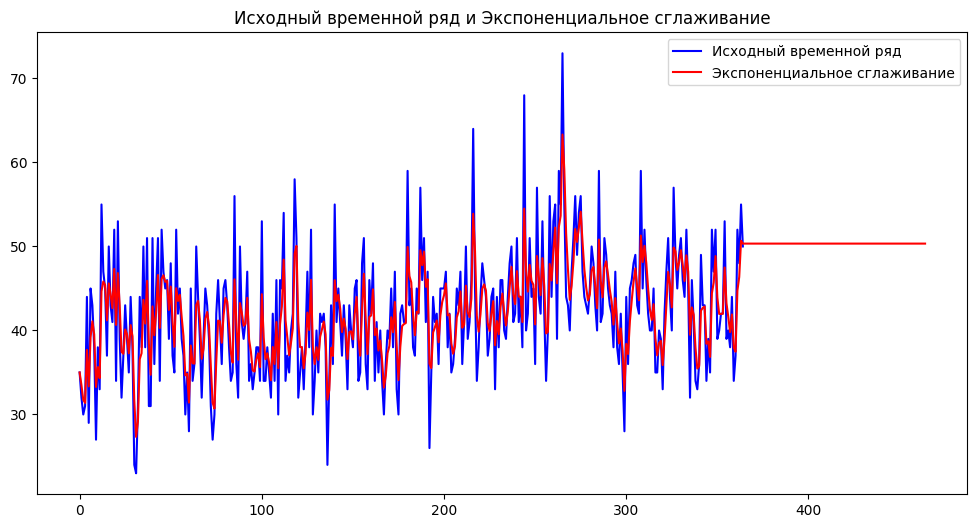

In [168]:
def exponential_moving_average(series, alpha, n_pred):
    result = [series.iloc[0]]
    for n in range(1, len(series)):
        result.append(alpha * series.iloc[n] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)

    predictions = [result[-1]]
    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        predictions.append(res)
        result.append(res)

    return pd.Series(result[len(series):]), pd.Series(result)

def plot_for_ema(series, alpha, n_pred):
    ema_series, ema_result = exponential_moving_average(series, alpha, n_pred)
    plt.figure(figsize=(12, 6))
    plt.plot(series1, label='Исходный временной ряд', color='blue')
    plt.plot(ema_result, label='Экспоненциальное сглаживание', color='red')
    plt.title('Исходный временной ряд и Экспоненциальное сглаживание')
    plt.legend()
    plt.show()

# Пробуем предсказать на 100 дней вперед с произвольным коэффициентом alpha (ожидаемо получаем выход на плато):
ser = series1
plot_for_ema(ser, alpha=0.5, n_pred=100)


Подберем коэффициент alpha автоматически. Для этого напишем функции для вычиления экспоненциального скользящего среднего, функцию высиления среднеквадратичной ошибки и функцию оптимизации параметра альфа по среднеквадратичной ошибки на основе метода градиентного спуска.

In [146]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [161]:
from sklearn.metrics import mean_squared_error

def ema(series, alpha, n_pred):
    result = [series.iloc[0]]
    for n in range(1, len(series)):
        result.append(alpha * series.iloc[n] + (1 - alpha) * result[n-1])

    # Если n_pred равно 0, возвращаем только EMA для исходной серии
    if not n_pred:
        return pd.Series(result)

    # Расчет прогнозов
    predictions = [result[-1]]
    for _ in range(1, n_pred):
        predictions.append(alpha * predictions[-1] + (1 - alpha) * result[-1])

    # Возвращаем прогнозы
    return pd.Series(predictions)

def mse_ema(X, *args):
    train, test = args
    alpha = X[0]
    predictions = ema(train, alpha, len(test))
    error = mean_squared_error(test, predictions)
    return error

In [163]:
# Функция для оптимизации alpha
def optimize_alpha(train, test):
    optimal_result = minimize(mse_ema, [0.0], args=(train, test), bounds=[(0.00, 1.00)], method='L-BFGS-B')
    return optimal_result.x[0]

# Разделим данные на train, test, val
train, test, val = series1[:200], series1[200:300], series1[300:]
optimal_alpha = optimize_alpha(train, test)
print(f'Оптимальное значение alpha: {optimal_alpha}')

# Проверким данные на val
val_predictions = exponential_moving_average(pd.concat([train, test]), optimal_alpha, len(val))
val_error = mean_squared_error(val, val_predictions)
print(f'Ошибка MSE на val: {val_error}')

Оптимальное значение alpha: 1.0
Ошибка MSE на val: 283.55384615384617


Отразим результаты на графике (графики совпадают, так как благодаря коээфициенту удается аппроксимировать модель временного ряда).

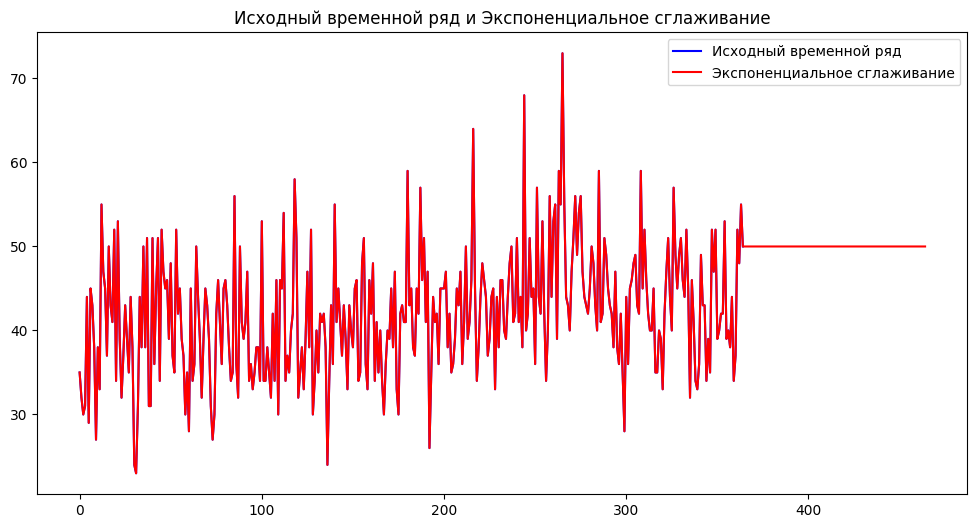

In [171]:
plot_for_ema(ser, alpha=1.0, n_pred = 100)

Нестационарный ряд с трендом и сезонностью

In [177]:
series2 = pd.read_csv("/content/international-airline-passengers.csv")['Count']

Приблизим нестационарный ряд с помощью метода TEMA, так как он позволяет учитывать наличие сезонности и тренда

In [208]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series) / slen)
    # вычисляем средние за сезон
    for j in range(n_seasons):
        sm = sum(series[slen * j : slen * j + slen]) # суммируем все значения внутри сезона
        season_averages.append(sm / float(slen))
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            # суммируем отклонения от средних по каждой i-ой компоненте каждого блока (сезона)
            sum_of_vals_over_avg += series[slen * j + i] - season_averages[j]
        # усредняем
        seasonals[i] = sum_of_vals_over_avg / float(n_seasons)
    # получаем список средних значений каждой i-ой компоненты сезона (между сезонами)
    return seasonals

def tema(series, slen, alpha, beta, gamma, n_preds):
    result = []
    for i in range(len(series) + n_preds):
        # описание
        if i < len(series):
            val = series[i]
            # инициализация
            if len(result) == 0:
                smooth = val
                trend = (series[slen] - series[0]) / float(slen)
                seasonals = initial_seasonal_components(series, slen)
                result.append(smooth)
            else:
                last_smooth = smooth
                smooth = alpha * (val - seasonals[i % slen]) + (1 - alpha) * (smooth + trend)
                trend = beta * (smooth - last_smooth) + (1 - beta) * trend
                seasonals[i % slen] = gamma * (val - smooth) + (1 - gamma) * seasonals[i%slen]
                result.append(smooth + trend + seasonals[i % slen])
        # прогноз
        else:
            m = i - len(series) + 1
            result.append((smooth + m * trend) + seasonals[i % slen])
    return result

def plot_tema(ser, slen, alpha, beta, gamma, n_preds, ser_plot=None, title_append=None):
    if ser_plot is None:
        ser_plot = ser
    title = f"alpha={alpha}, beta={beta}, gamma={gamma}"
    if title_append is not None:
        title += " " + title_append
    t = tema(ser, slen, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series2, color='blue',label='original')
        plt.plot(t[:len(ser)], color='red', label='TEMA')
        plt.plot([x + len(ser) for x in range(-1, n_preds)], t[len(ser) - 1:], color='green', label='TEMA prediction')
        plt.title(title)
        plt.legend()
        plt.show()

Построим график прогноза с произвольными параметрами альфа, бета и гамма

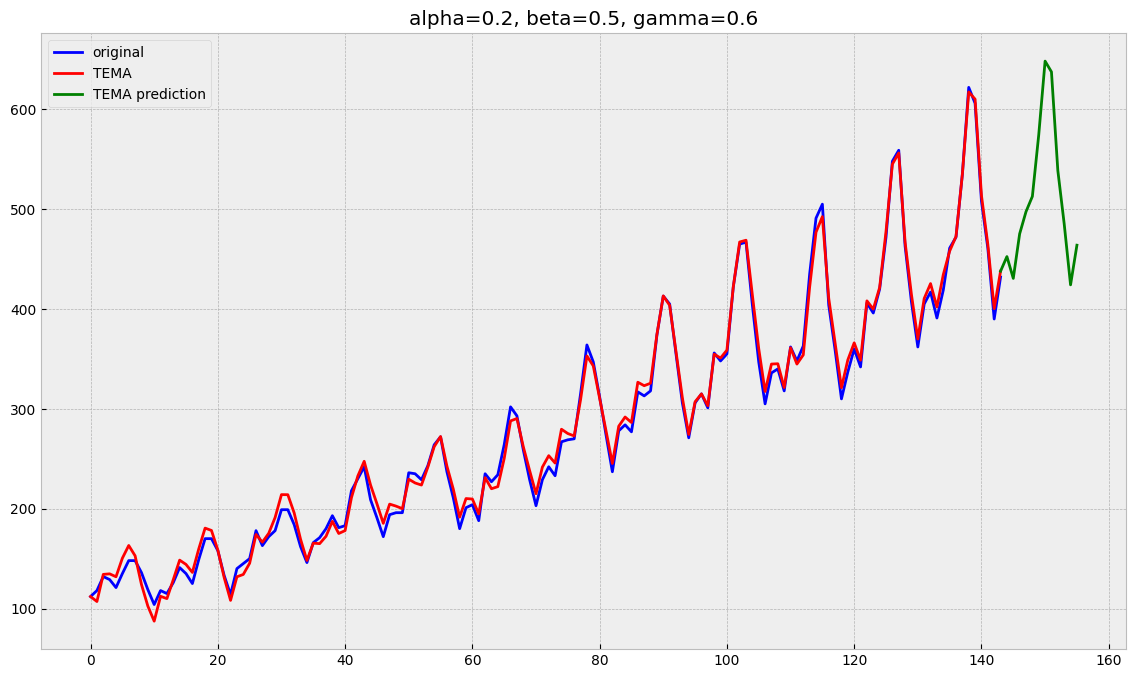

In [209]:
plot_tema(series2, 12, 0.2, 0.5, 0.6, 12, 24)

Реализуем автоматический подбор параметров путем оптимизации на основе минимизации среднеквадратичной ошибки и с помощью методов градиентного спуска

In [212]:
def mse_tema(X, *args):
    train = args[0]
    test = args[1]
    slen = args[2]
    alpha, beta, gamma = X
    res = tema(train, slen, alpha, beta, gamma, len(test))
    predictions = res[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [214]:
train, test, val = series2[:100], series2[100:120], series2[120:]

In [215]:
opt = minimize(mse_tema, [0, 0, 0], args=(train, test, 12), bounds=((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
print(f"alpha: {alpha_opt}, beta: {beta_opt}, gamma: {gamma_opt}.")

alpha: 1.0, beta: 0.01052918100484032, gamma: 1.0.


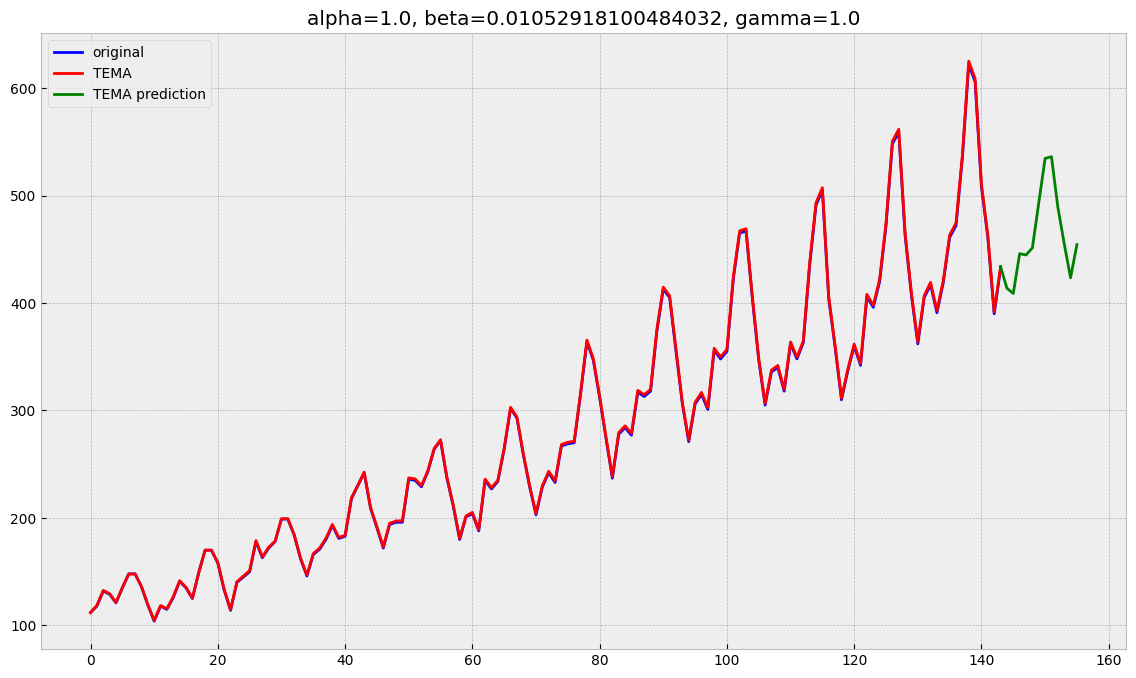

In [219]:
plot_tema(series2, 12, alpha_opt, beta_opt, gamma_opt, 12)

Вывод: графики совпадают при подобранных парметрах альфа, бета и гамма. Предсказание становится более усредненным.